# 3. Principal Component Analysis

This notebook implements the PCA tasks on the 'Communities and Crime' dataset.

### Thoughts on Project / Interesting Questions to investigate

- What are the two groups we can see in the range normalized PCA projection?

- Why is it so much better with more features? Wrong features selected (see next question)?
    - In what way is it better? In regards to being able to seperate different crime rate communities 11 features is better - one can actually predict the class of crime quite well. With our six selected features interestingly enough a different structure appears. Which doesn't seperate by crime rate, even though communites with a high crime rate are in the same area. (Perhaps influence of pctUrban?)
    
    
- Is approach to select the six features with the highest correlation with crime rate sensible? Or would it be better to use covariance / variance?
    - positive and negative correlation according to feedback from professor - what exactly is meant here?
    - Decreasing and increasing crime rate / should we have a look at them seperately?
    
    - in regards to covariance / variance -> that's a possible thing to test for further analysis
    - look at distribution of all features and see which are not normally distributed -> two groups could come from rural / non-rural bimodal distribution?
    - Look at influence of pctUrban on PCA algorithm structure -> dividing groups into two groups
    

- Why is range normalisation so much better in maintaining variance? (95% of cum. exp. var vs. 75 % of cum. exp. var)
    - if pctUrban is a big part of the variance (how can we check that?) then would range be better than sdv normalization? => Range normalization would more or less maintain same values as percentage Is already range normalized. Sdv might have weird effects on it, because of it's bimodal distribution.
    - We don't have normally distributed data! Sdv normalization kind of assumes normal distribution right?
    
- Discuss PCA vs. SDV

#### Academic Questions: 
- Normal distribution is probably maintained during PCA ?


### Plan for Report


#### Import modules and load data

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

#interactive plot
# Please consult information to update plotly.offline 
# e.g. https://medium.com/plotly/plotly-py-4-0-is-here-offline-only-express-first-displayable-anywhere-fc444e5659ee
from plotly.offline import plot
# TODO: Figure out where exactly import * is needed and remove it (bad style)
from plotly.graph_objs import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots

data = pd.read_csv('../data/communities_processed.csv')
# Create df we are going to work with as a copy so that we can always
# access unaltered data when necessary
df = data.copy()

print(df.head())

   population  householdsize  agePct12t29  agePct65up  medFamInc  \
0       11980           3.10        21.44       11.33      79584   
1       23123           2.82        21.30       17.18      55323   
2       29344           2.43        25.88       10.28      42112   
3       16656           2.40        25.20       17.57      26501   
4       11245           2.76        40.53       12.65      24018   

   PctPopUnderPov  MedRentPctHousInc  TotalPctDiv  PctLargHouseFam  pctUrban  \
0            1.96                316         4.47             4.81     100.0   
1            3.98                205         5.42             4.25     100.0   
2            4.75                150        12.55             2.97     100.0   
3           17.23                114        12.91             3.93       0.0   
4           29.99                160         9.73             5.23       0.0   

   PctHousOccup  ViolentCrimesPerPop  
0         98.37                  0.0  
1         97.15                 

### Setup
Define utiltiy methods used during analysis:

In [208]:
def create_pca_plot_2D(df, colors):
    
    principal=PCA(n_components=2)
    principal.fit(df)
    x = principal.transform(df)
    principalDf = pd.DataFrame(data = x)

    fig = plt.figure(figsize=(10,10))

    # choose projection 3d for creating a 3d graph
    axis = fig.add_subplot(111)

    # x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
    axis.scatter(x[:, 0], x[:, 1], c=colors, cmap='hot')
    axis.set_xlabel("PC1", fontsize=10)
    axis.set_ylabel("PC2", fontsize=10)
    plt.show()
    
def create_pca_plot_3D(df, colors):
    
    principal=PCA(n_components=3)
    principal.fit(df)
    x=principal.transform(df)
    principalDf = pd.DataFrame(data = x)

    fig = plt.figure(figsize=(10,10))

    # choose projection 3d for creating a 3d graph
    axis = fig.add_subplot(111, projection='3d')

    # x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
    axis.scatter(x[:, 0], x[:, 1], x[:, 2], c=colors, cmap='hot')
    axis.set_xlabel("PC1", fontsize=10)
    axis.set_ylabel("PC2", fontsize=10)
    axis.set_zlabel("PC3", fontsize=10)
    plt.show()

In [241]:
def create_pca_quality_plot(df, n_components):
    # Obtain the eigenvalues and eingenvectors of covariance matrix
    # The eigenvalues are not necessarily ordered

    covmatrix = df.cov()

    e, v = np.linalg.eig(covmatrix)

    totVar = sum(e)       #Total variability of the Data
    var_exp = [(i / totVar)*100 for i in sorted(e, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)

    trace1 = Bar(
            x=['PC %s' %i for i in range(1, n_components + 1)],
            y=var_exp,
            name='Exp Var',
            showlegend=False)

    trace2 = Scatter(
            x=['PC %s' %i for i in range(1, n_components + 1)], 
            y=cum_var_exp,
            name='Cum. Exp Var')

    plot_data = [trace1, trace2]

    layout=Layout(
            yaxis=YAxis(title='Explained variance in percent'),
            title='Explained variance by different principal components with previous feature selection')

    fig = Figure(data=plot_data, layout=layout)
    
    plot(fig)

Have a look at distributions in our features for following analysis.

In [288]:
fig = make_subplots(rows=4, cols=3, start_cell="top-left")

for index, feature in zip(range(0, 11), df):
    fig.add_trace(go.Histogram(x = df[feature],  name=feature), row = (index % 4) + 1, col= (index % 3) + 1)
    xaxis_id = 'xaxis' if index == 0 else f'xaxis{index}'
    #fig['layout'][xaxis_id]['title']= feature, needs work to bring in labels

fig.show()

### 1. Feature Selection

> Select a subset of 3 to 6 features related to the same aspect of the phenomenon to which your data set relates to.  Explain your choice.

We want to how well the prediction power of our socio-economic features for community crime rate can be conserved when projected to a lower-dimension. As a simple heuristic we therefore select the six features of our feature set with the highest correlation with the crime rate.

#Todo: Should we take covariance or correlation here? Or even variance within itself?

To be able to compare the correlation we first have to normalize our data.

In [255]:
3 % 3

0

In [20]:
#TODO: Should we use other normalization (range) normalization here?

feature_columns = ['population', 'householdsize', 'agePct12t29', 'agePct65up',
                       'medFamInc', 'PctPopUnderPov', 'MedRentPctHousInc', 'TotalPctDiv',
                       'PctLargHouseFam', 'pctUrban', 'PctHousOccup']

# Remove group variable 'ViolentCrimesPerPop' before normalization
df = df.drop('ViolentCrimesPerPop', axis=1)

# Scale data before selecting features
scaling=StandardScaler()

# Use fit and transform method
scaling.fit(df)
scaled_data = scaling.transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=feature_columns)
df_scaled = pd.concat((df_scaled, data.ViolentCrimesPerPop), 1)
df_scaled.head()

/var/folders/c1/x6x0_kk160d5b7dytdt209dw0000gn/T/ipykernel_13076/1380402788.py:15: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_scaled = pd.concat((df_scaled, data.ViolentCrimesPerPop), 1)


,population,householdsize,agePct12t29,agePct65up,medFamInc,PctPopUnderPov,MedRentPctHousInc,TotalPctDiv,PctLargHouseFam,pctUrban,PctHousOccup,ViolentCrimesPerPop
0,-0.201091,1.175511,-1.004000,-0.106018,2.788249,-1.123526,1.393576,-2.114026,-0.152004,0.670172,1.078663,0.0
1,-0.146622,0.337299,-1.026653,1.118732,1.085483,-0.888599,0.090552,-1.797381,-0.299626,0.670172,0.836580,0.0
2,-0.116212,-0.830211,-0.285567,-0.325845,0.158264,-0.799047,-0.555091,0.579122,-0.637050,0.670172,0.544890,0.0
3,-0.178234,-0.920020,-0.395597,1.200382,-0.937399,0.652384,-0.977693,0.699114,-0.383982,-1.598929,-0.346054,0.0
4,-0.204684,0.157682,2.084936,0.170336,-1.111670,2.136379,-0.437701,-0.360813,-0.041287,-1.598929,-0.096034,0.0


We then select the six socio-economic features with the highest covariance with 'ViolentCrimesPerPop'.

In [45]:
corr = df_scaled.corr()
feature_corr = [(corr.loc[feature, 'ViolentCrimesPerPop'],feature) for feature in corr if not feature == 'ViolentCrimesPerPop']
sorted(feature_corr, key=lambda tup: -abs(tup[0]))

[(0.23625442517213338, 'TotalPctDiv'),
 (0.22046309654342172, 'pctUrban'),
 (0.19620932852535872, 'population'),
 (0.167550281902225, 'PctPopUnderPov'),
 (-0.1158931512879374, 'medFamInc'),
 (0.09904327886790373, 'PctLargHouseFam'),
 (-0.08414989226247573, 'PctHousOccup'),
 (-0.08214046440401872, 'householdsize'),
 (0.08131061204208379, 'agePct12t29'),
 (0.017802237479375805, 'MedRentPctHousInc'),
 (-0.00024809994212165185, 'agePct65up')]

In [77]:
features_sorted_by_corr = sorted(feature_corr, key=lambda tup: -abs(tup[0]))
selected_features = [tup[1] for tup in features_sorted_by_corr[:6]]
selected_features

['TotalPctDiv',
 'pctUrban',
 'population',
 'PctPopUnderPov',
 'medFamInc',
 'PctLargHouseFam']

### 2. Visualization in 2D / 3D PC Plane

> Visualize the data over these features in 2D/3D PC plane using two types of normalization: by range and by standard deviations.

In [88]:
# Do PCA over features: 'TotalPctDiv','pctUrban','population','PctPopUnderPov','medFamInc','PctLargHouseFam'
df_selected = df[selected_features]
df_selected

,TotalPctDiv,pctUrban,population,PctPopUnderPov,medFamInc,PctLargHouseFam
0,4.47,100.00,11980,1.96,79584,4.81
1,5.42,100.00,23123,3.98,55323,4.25
2,12.55,100.00,29344,4.75,42112,2.97
3,12.91,0.00,16656,17.23,26501,3.93
4,9.73,0.00,11245,29.99,24018,5.23
...,...,...,...,...,...,...
2210,13.34,100.00,56216,25.06,27388,13.49
2211,13.77,100.00,12251,20.79,25000,5.03
2212,11.23,100.00,32824,7.56,34973,5.10
2213,12.48,0.00,13547,30.32,22103,9.83


#### Normalizations

In [93]:
# Range normalization

df_range_norm = (df_selected - df_selected.min()) / (df_selected.max() - df_selected.min())
print(df_range_norm.head())

# Standard deviation normalization
 
df_sdv_norm = (df_selected - df_selected.mean()) / df_selected.std()
print(df_sdv_norm.head())

   TotalPctDiv  pctUrban  population  PctPopUnderPov  medFamInc  \
0     0.084536       1.0    0.000270        0.023013   0.537776   
1     0.133505       1.0    0.001794        0.058229   0.349064   
2     0.501031       1.0    0.002645        0.071653   0.246303   
3     0.519588       0.0    0.000910        0.289226   0.124875   
4     0.355670       0.0    0.000170        0.511681   0.105561   

   PctLargHouseFam  
0         0.113536  
1         0.097022  
2         0.059275  
3         0.087585  
4         0.125922  
   TotalPctDiv  pctUrban  population  PctPopUnderPov  medFamInc  \
0    -2.113549  0.670021   -0.201046       -1.123272   2.787620   
1    -1.796976  0.670021   -0.146589       -0.888398   1.085238   
2     0.578991  0.670021   -0.116186       -0.798867   0.158228   
3     0.698956 -1.598568   -0.178193        0.652236  -0.937188   
4    -0.360732 -1.598568   -0.204638        2.135897  -1.111419   

   PctLargHouseFam  
0        -0.151969  
1        -0.299559  
2    

#### 2D Plane with range normalization

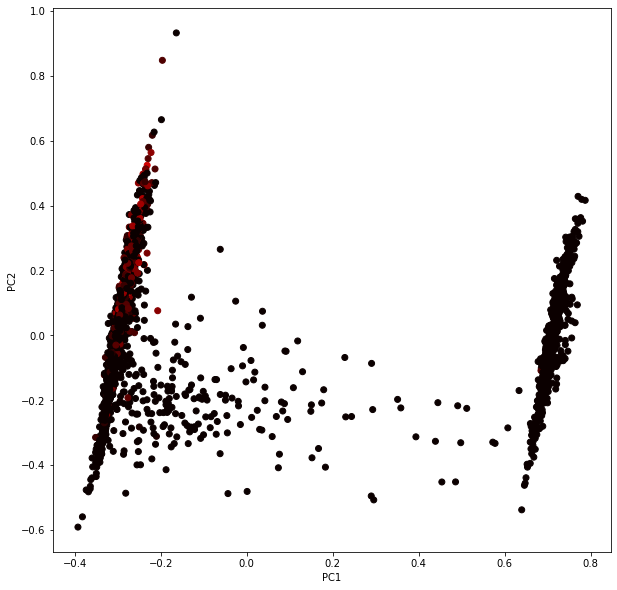

In [209]:
create_pca_plot_2D(df_range_norm, data.ViolentCrimesPerPop)

#### 3D Plane with range normalization

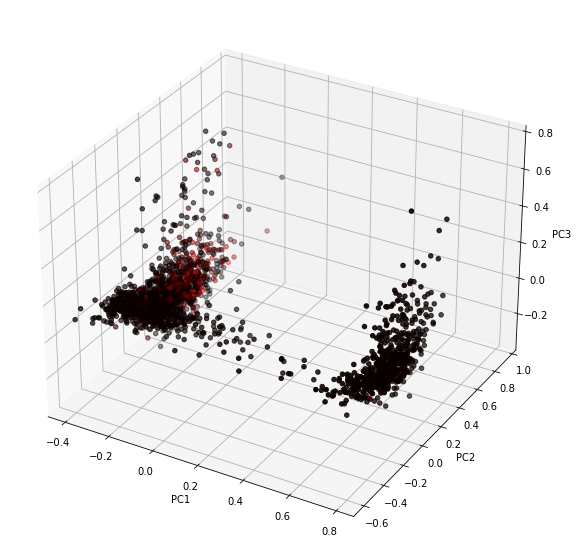

In [210]:
create_pca_plot_3D(df_range_norm, data.ViolentCrimesPerPop)

#### 2D Plane with Standard Deviation Normalization

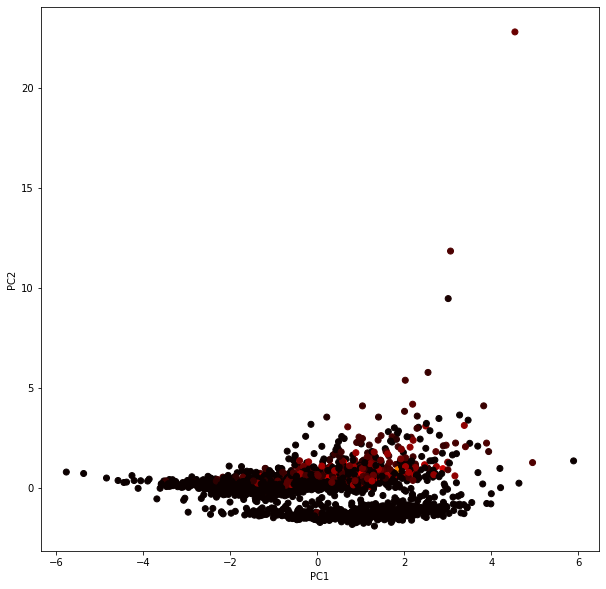

In [211]:
create_pca_plot_2D(df_sdv_norm, data.ViolentCrimesPerPop)

#### 3D Plane with Standard Deviation Normalization

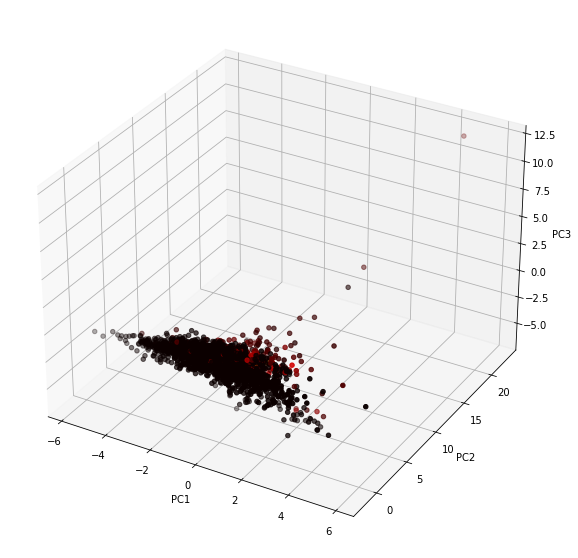

In [212]:
create_pca_plot_3D(df_sdv_norm, data.ViolentCrimesPerPop)

### 3. Comment on PCA vs. SVD and Normalization Quality
Choose between conventional PCA or SVD for the visualization. Make a comment whether one of the normalizations is better and why.

- PCA can be used easily because we don't have a sparse matrix or a lot of data leading to performance problems
- #TODO: Test with SVD?

- Range normalization is better because with visual inspection it appears to maintain a higher amount of variation in our data

### 4.  Pre-specified group

At these visualizations, use a distinct shape/colour for data points representing a pre‐specified, by yourself, group of objects. Comment on the choice of your groups.

Groups: Level of crime 

<AxesSubplot:>

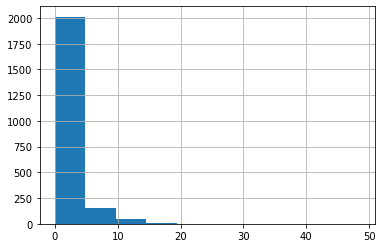

In [108]:
data.ViolentCrimesPerPop.hist()

<AxesSubplot:>

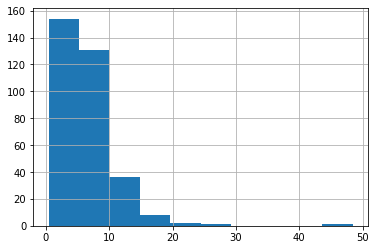

In [107]:
data_w_crime = data.ViolentCrimesPerPop[data.ViolentCrimesPerPop != 0.0]
data_w_crime.hist()

In [139]:
categorized_crime_rate = pd.cut(data.ViolentCrimesPerPop, bins=[0.0, 5, 10, 100] ,labels=['low', 'middle', 'high'], include_lowest=True)
categorized_crime_rate.head(20)

0        low
1        low
2        low
3        low
4        low
5        low
6        low
7        low
8        low
9     middle
10       low
11       low
12       low
13      high
14       low
15       low
16       low
17    middle
18       low
19    middle
Name: ViolentCrimesPerPop, dtype: category
Categories (3, object): ['low' < 'middle' < 'high']

In [216]:
color_dict = {
    'low': 'blue',
    'middle': 'yellow',
    'high': 'red'
}

categorical_crime_colors = [color_dict[i] for i in categorized_crime_rate]

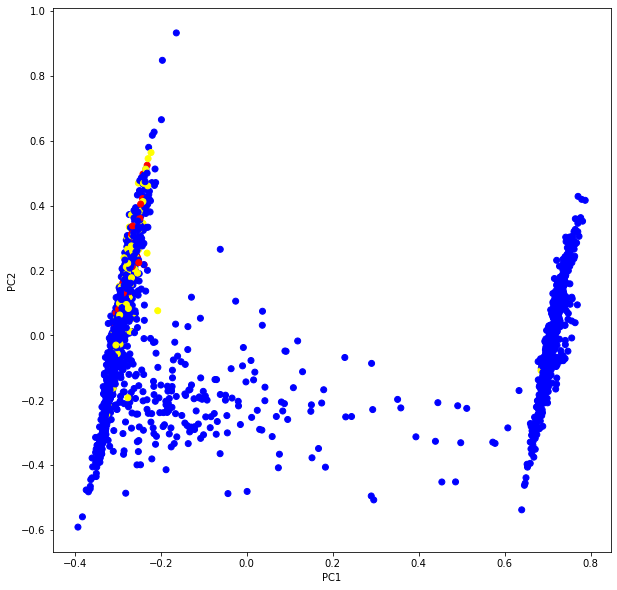

In [217]:
create_pca_plot_2D(df_range_norm, categorical_crime_colors)

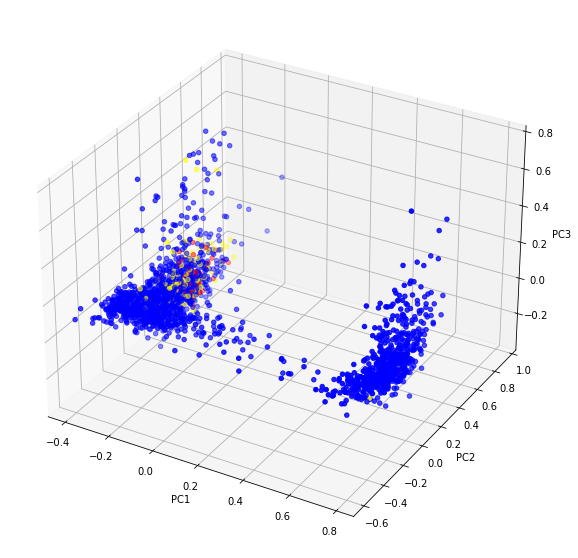

In [218]:
create_pca_plot_3D(df_range_norm, categorical_crime_colors)

### 5. Quality of PC projection

Calculate and make a graphical presentation of the “quality” of the PC projection of your data. Discuss your results.

In [148]:
df_range_norm.cov()

,TotalPctDiv,pctUrban,population,PctPopUnderPov,medFamInc,PctLargHouseFam
TotalPctDiv,0.023927,-0.002299,0.000508,0.010129,-0.009766,0.001184
pctUrban,-0.002299,0.194307,0.001410,-0.020511,0.015836,0.003262
population,0.000508,0.001410,0.000783,0.000400,-0.000178,0.000360
PctPopUnderPov,0.010129,-0.020511,0.000400,0.022481,-0.012120,0.006052
medFamInc,-0.009766,0.015836,-0.000178,-0.012120,0.012288,-0.002900
PctLargHouseFam,0.001184,0.003262,0.000360,0.006052,-0.002900,0.012520


In [242]:
create_pca_quality_plot(df_range_norm, 3)

#### Quality of standard deviation normalisation for PCA:

In [243]:
create_pca_quality_plot(df_sdv_norm, 3)

### 6. Comparison to with whole dataset

In [230]:
df_scaled.head()

,population,householdsize,agePct12t29,agePct65up,medFamInc,PctPopUnderPov,MedRentPctHousInc,TotalPctDiv,PctLargHouseFam,pctUrban,PctHousOccup,ViolentCrimesPerPop
0,-0.201091,1.175511,-1.004000,-0.106018,2.788249,-1.123526,1.393576,-2.114026,-0.152004,0.670172,1.078663,0.0
1,-0.146622,0.337299,-1.026653,1.118732,1.085483,-0.888599,0.090552,-1.797381,-0.299626,0.670172,0.836580,0.0
2,-0.116212,-0.830211,-0.285567,-0.325845,0.158264,-0.799047,-0.555091,0.579122,-0.637050,0.670172,0.544890,0.0
3,-0.178234,-0.920020,-0.395597,1.200382,-0.937399,0.652384,-0.977693,0.699114,-0.383982,-1.598929,-0.346054,0.0
4,-0.204684,0.157682,2.084936,0.170336,-1.111670,2.136379,-0.437701,-0.360813,-0.041287,-1.598929,-0.096034,0.0


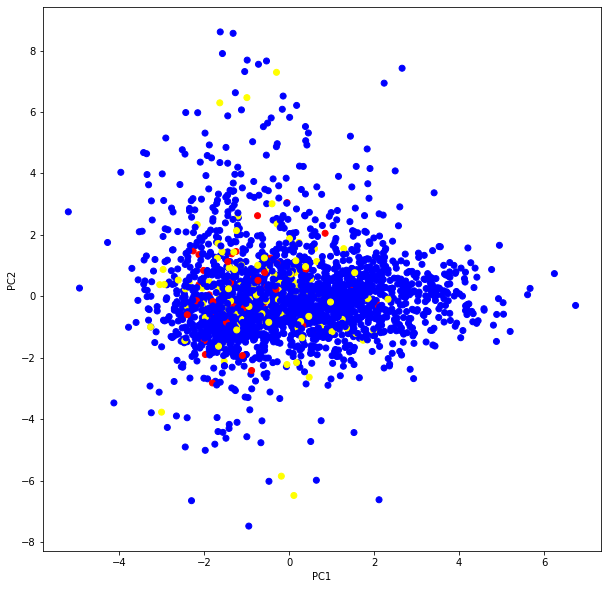

In [233]:
create_pca_plot_2D(df_scaled.drop('ViolentCrimesPerPop', axis=1), categorical_crime_colors)

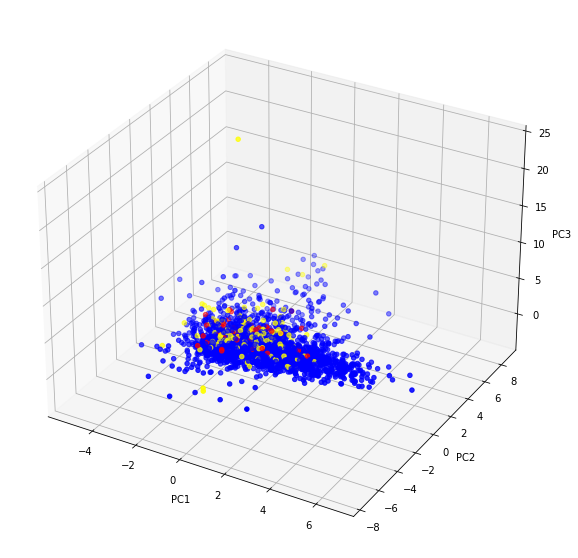

In [234]:
create_pca_plot_3D(df_scaled.drop('ViolentCrimesPerPop', axis=1), categorical_crime_colors)

In [244]:
df_all_range_norm = (df - df.min()) / (df.max() - df.min())
print(df_all_range_norm.head())

   population  householdsize  agePct12t29  agePct65up  medFamInc  \
0    0.000270       0.407609     0.197284    0.189200   0.537776   
1    0.001794       0.331522     0.194994    0.303659   0.349064   
2    0.002645       0.225543     0.269917    0.168656   0.246303   
3    0.000910       0.217391     0.258793    0.311289   0.124875   
4    0.000170       0.315217     0.509570    0.215026   0.105561   

   PctPopUnderPov  MedRentPctHousInc  TotalPctDiv  PctLargHouseFam  pctUrban  \
0        0.023013           0.393524     0.084536         0.113536       1.0   
1        0.058229           0.255293     0.133505         0.097022       1.0   
2        0.071653           0.186800     0.501031         0.059275       1.0   
3        0.289226           0.141968     0.519588         0.087585       0.0   
4        0.511681           0.199253     0.355670         0.125922       0.0   

   PctHousOccup  ViolentCrimesPerPop  
0      0.989761                  0.0  
1      0.969933                 

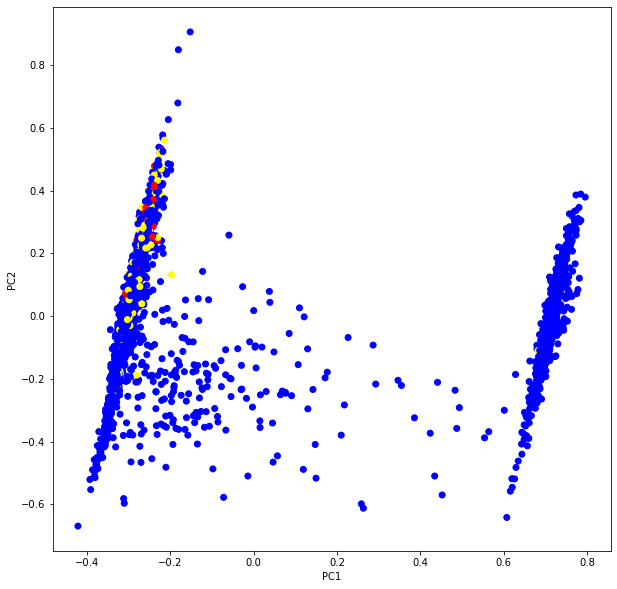

In [235]:
create_pca_plot_2D(df_all_range_norm.drop('ViolentCrimesPerPop', axis=1), categorical_crime_colors)

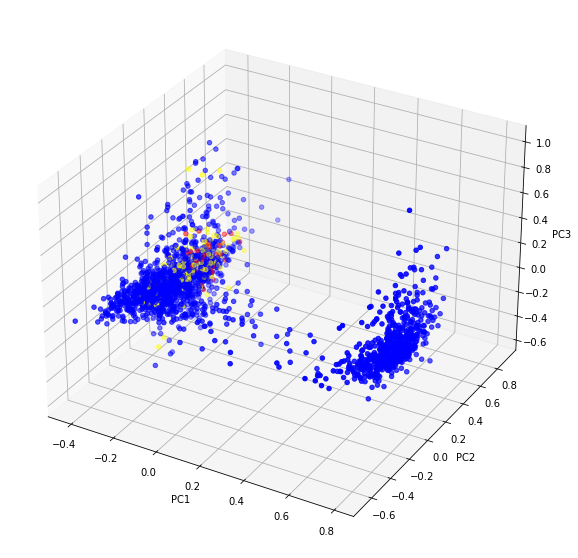

In [246]:
create_pca_plot_3D(df_all_range_norm.drop(['ViolentCrimesPerPop'], axis=1), categorical_crime_colors)